# Toy Problem: Predicting "Stickiness" (Proxy for Developability) from a Short Peptide Sequence
### Goal: Simulate predicting a simple protein property (like aggregation propensity or "stickiness") from a short peptide sequence to explore the performance of different sequence representations and model types.

### Scenario: We have a library of 10-amino acid peptides. For each peptide, we've measured a hydrophobic interaction chromatography (HIC) retention time or proxy. Our goal is to train a model to predict HIC retention time from the peptide sequence.


### Generating Toy Data

Define Alphabet: Standard 20 amino acids.
Generate Random Sequences: Create, say, 1,000 random 10-amino acid peptides.
Compute retention time (RT) using a fake physical relationship between sequence and HIC RT. Individual amino acids contribute linearly to the RT (hydrophobic AAs positively, hydrophilic AAs negatively). A non-linear motif effect is added to give the models a more complex pattern to learn.
Add some random noise to simulate experimental variability.

### Sequence Representations

One-Hot Encoding: Convert each amino acid into a binary vector. The whole sequence becomes a 2D matrix.

Physicochemical Features: For each amino acid in the sequence, use pre-defined properties (e.g., hydrophobicity index, surface area). Both position-wise and an aggregated quantity per sequence.

Protein Language Model Embedding (from ESM2): Each sequence is represented by a ~700 x 1 vector after pLM embedding.

### Phase 3: Model Building

Models tested include:
Multiple linear regression
Random Forest Regression
Simple Feed-Forward Neural Network (MLP)

For RF regression and the neural net, scan number of estimators and neural network dimensions to find the best model architecture considering both train and test set performance.

Set up a new model instance for every sequence representation.


### Training and Evaluation

Cross-validation - 5-fold random train-test splitting, standardization, training, and evaluation of model performance on a test set using RMSE and R-squared as evaluation metrics.

In [70]:
# Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

In [71]:
# Function definitions
# --- Phase 1: Generating Toy Data ---

# 1. Define Alphabet and Physicochemical Properties
# Using simplified Kyte-Doolittle hydrophobicity and a generic 'surface area' proxy
# (Note: These are simplified for a toy model, real values would be more nuanced)
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

# Example hydrophobicity scale (Kyte-Doolittle, simplified)
# Higher value = more hydrophobic
HYDROPHOBICITIES = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2,
    'I': 4.5, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5,
    'R': -4.5, 'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}


# Example 'surface area' proxy (simplified, just for this toy model)
# Could represent how much an amino acid contributes to exposed surface
SURFACE_AREAS = {
    'A': 1.0, 'C': 1.2, 'D': 1.5, 'E': 1.6, 'F': 2.0, 'G': 0.8, 'H': 1.7,
    'I': 1.8, 'K': 1.9, 'L': 1.7, 'M': 1.8, 'N': 1.4, 'P': 1.1, 'Q': 1.5,
    'R': 2.0, 'S': 1.0, 'T': 1.1, 'V': 1.5, 'W': 2.2, 'Y': 2.0
}

# Approximate natural protein AA distribution (simplified for toy data)
# Source: Based on general frequencies, not precise
AA_DISTRIBUTION = {
    'A': 0.08, 'C': 0.01, 'D': 0.05, 'E': 0.06, 'F': 0.04, 'G': 0.07, 'H': 0.02,
    'I': 0.05, 'K': 0.06, 'L': 0.09, 'M': 0.02, 'N': 0.04, 'P': 0.05, 'Q': 0.04,
    'R': 0.05, 'S': 0.07, 'T': 0.05, 'V': 0.06, 'W': 0.01, 'Y': 0.03
}
# Ensure the probabilities sum to 1 (adjusting for potential floating point inaccuracies)
total_prob = sum(AA_DISTRIBUTION.values())
AA_PROBS = [AA_DISTRIBUTION[aa] / total_prob for aa in AMINO_ACIDS]


def calculate_rt(sequence: str) -> float:
    """
    Calculates a 'retention time' score for a peptide sequence based on
    hydrophobicity, surface area, and additional position-dependent and motif effects.
    Adds random noise to simulate experimental variability.
    """
    base_score = 10.0

    # Let's say that the surface area of a position depends on the sequence context
    # N- and C-termini automatically have a multiplier of 1
    # AAs that have a hydrophobic AA on the N-term side get their SASA reduced by 1/2.
    # AAs with a hydrophobic AA on both sides have SASA reduced by 8

    #Handle N-term
    base_score += HYDROPHOBICITIES.get(sequence[0], 0) * SURFACE_AREAS.get(sequence[0], 0)

    for mid in range(1, len(sequence)-1):
        if HYDROPHOBICITIES.get(sequence[mid-1], 0) > 0:
            if HYDROPHOBICITIES.get(sequence[mid+1], 0) > 0: # divide SASA by 8
                base_score += HYDROPHOBICITIES.get(sequence[mid], 0) * SURFACE_AREAS.get(sequence[mid], 0) / 8

            else: #divide SASA by 2
                base_score += HYDROPHOBICITIES.get(sequence[mid], 0) * SURFACE_AREAS.get(sequence[mid], 0) / 2
        else: # N-term position is polar - SASA multipler is 1
            base_score += HYDROPHOBICITIES.get(sequence[mid], 0) * SURFACE_AREAS.get(sequence[mid], 0)

    # --- Add secondary, position-dependent, and motif effects ---

    # N-terminal and C-terminal effects
    # Using the global HYDROPHOBICITIES dictionary
    n_term_bonus = HYDROPHOBICITIES.get(sequence[0], 0) * 0.5
    c_term_bonus = HYDROPHOBICITIES.get(sequence[-1], 0) * 0.3
    
    # Aromatic clustering (Phe, Trp, Tyr together increase retention)
    aromatic = ['F', 'W', 'Y']
    aromatic_clusters = 0
    for i in range(len(sequence) - 1):
        if sequence[i] in aromatic and sequence[i+1] in aromatic:
            aromatic_clusters += 1
            
    # Charge repulsion (consecutive charged residues decrease retention)
    charged_pos = ['K', 'R', 'H']
    charged_neg = ['D', 'E']
    charge_penalty = 0
    for i in range(len(sequence) - 1):
        if (sequence[i] in charged_pos and sequence[i+1] in charged_pos) or \
           (sequence[i] in charged_neg and sequence[i+1] in charged_neg):
            charge_penalty += 0.8 # Each consecutive pair adds a penalty

    # Curveball sequence dependence unrelated to the physicochemical properties we are tracking
    # Say if a sequence contains an aromatic and positive charge, 

            
    # Bonus rule: if the sequence contains 'WW', add a significant bonus (kept from previous version)
    ww_bonus = 0.0
    if 'WW' in sequence:
        ww_bonus = 5.0 # A strong positive effect on retention time

    # Combine all effects
    #total_score = base_score + n_term_bonus + c_term_bonus + \
    #              (aromatic_clusters * 1.2) + (hydrophobic_clusters*1.05) - charge_penalty + ww_bonus

    total_score = base_score + n_term_bonus + c_term_bonus + \
                (aromatic_clusters + ww_bonus) - charge_penalty
    # Add random Gaussian noise to simulate experimental variability
    # Mean 0, standard deviation 2.0 (you can adjust this)
    noise = np.random.normal(loc=0, scale=2.0)
    total_score += noise

    # Ensure score is non-negative and within a reasonable range (optional, for realism)
    total_score = max(0.0, total_score)
    return total_score


def generate_sequence(sequence_length: int) -> str:
    """
    Generates a random peptide sequence of a given length, drawing amino acids
    based on a natural protein amino acid distribution.
    """
    return ''.join(random.choices(AMINO_ACIDS, weights=AA_PROBS, k=sequence_length))


def create_dataset(num_sequences: int = 1000, sequence_length: int = 10) -> pd.DataFrame:
    """
    Creates a synthetic dataset of peptide sequences and their calculated
    'retention time' scores.
    """
    print(f"Generating {num_sequences} sequences of length {sequence_length}...")
    seqs = []
    rts = []
    for i in range(num_sequences):
        seq = generate_sequence(sequence_length)
        seqs.append(seq)
        rts.append(calculate_rt(seq))
    
    dataset = pd.DataFrame({"Sequence": seqs, "Retention_time": rts})
    print("Dataset generation complete.")
    return dataset



In [72]:
# Test usage
toy_df = create_dataset(num_sequences=1000, sequence_length=10)
print("\nFirst 5 rows of the toy dataset:")
print(toy_df.head())
print(f"\nRetention time distribution (mean, std, min, max):")
print(toy_df['Retention_time'].describe())
    
# Check if 'WW' motif has higher RTs
ww_sequences = toy_df[toy_df['Sequence'].str.contains('WW')]
if not ww_sequences.empty:
    print(f"\nMean RT for sequences containing 'WW': {ww_sequences['Retention_time'].mean():.2f}")
    
non_ww_sequences = toy_df[~toy_df['Sequence'].str.contains('WW')]
if not non_ww_sequences.empty:
    print(f"Mean RT for sequences NOT containing 'WW': {non_ww_sequences['Retention_time'].mean():.2f}")

# Check for aromatic clusters
aromatic_peptides = toy_df[toy_df['Sequence'].apply(lambda s: any(s[i] in ['F', 'W', 'Y'] and s[i+1] in ['F', 'W', 'Y'] for i in range(len(s)-1)))]
if not aromatic_peptides.empty:
    print(f"\nMean RT for sequences with aromatic clusters: {aromatic_peptides['Retention_time'].mean():.2f}")

# Check for charge repulsion
charged_pos = ['K', 'R', 'H']
charged_neg = ['D', 'E']
charge_repulsion_peptides = toy_df[toy_df['Sequence'].apply(lambda s: any(
        (s[i] in charged_pos and s[i+1] in charged_pos) or
        (s[i] in charged_neg and s[i+1] in charged_neg) for i in range(len(s)-1)
    ))]
if not charge_repulsion_peptides.empty:
    print(f"Mean RT for sequences with charge repulsion: {charge_repulsion_peptides['Retention_time'].mean():.2f}")


Generating 1000 sequences of length 10...
Dataset generation complete.

First 5 rows of the toy dataset:
     Sequence  Retention_time
0  RFRSQQNMKK        0.000000
1  GAIYEVQISN       20.566351
2  DQEVKSVACG        1.521725
3  LAPRKKTSGE        0.000000
4  GDVQQPTMMD        2.330828

Retention time distribution (mean, std, min, max):
count    1000.000000
mean        9.341611
std         9.956839
min         0.000000
25%         0.000000
50%         7.015591
75%        15.933077
max        45.424392
Name: Retention_time, dtype: float64

Mean RT for sequences containing 'WW': 29.84
Mean RT for sequences NOT containing 'WW': 9.32

Mean RT for sequences with aromatic clusters: 9.10
Mean RT for sequences with charge repulsion: 3.96


In [73]:
# Exploring sequence representations
# One hot encoding, physicochemical properties, something with k-mers
# esm embedding
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_sequence(sequence: str) -> np.ndarray:
    """
    Converts a peptide sequence into a one-hot encoded representation.
    Each amino acid is represented as a binary vector of length 20.
    """
    encoder = OneHotEncoder(categories=[list(AMINO_ACIDS)], sparse_output=False)
    sequence_array = np.array(list(sequence)).reshape(-1, 1)
    one_hot_encoded = encoder.fit_transform(sequence_array)
    return one_hot_encoded

def one_hot_encode_sequences(sequences: pd.Series) -> np.ndarray:
    """
    Applies one-hot encoding to a series of peptide sequences.
    Returns a 3D numpy array where each sequence is represented as a 2D array.
    """
    encoded_sequences = [one_hot_encode_sequence(seq) for seq in sequences]
    return np.array(encoded_sequences)

def get_physicochemical_properties(sequence: str) -> np.ndarray:
    """
    Compute the mean hydrophobicity and surface area for a peptide sequence.
    Returns a 1D numpy array with these properties.
    """
    hydrophobicity = np.mean([HYDROPHOBICITIES.get(aa, 0) for aa in sequence])
    surface_area = np.mean([SURFACE_AREAS.get(aa, 0) for aa in sequence])
    return np.array([hydrophobicity, surface_area])
def get_physicochemical_properties_for_sequences(sequences: pd.Series) -> np.ndarray:
    """
    Applies physicochemical property calculations to a series of peptide sequences.
    Returns a 2D numpy array where each row corresponds to a sequence's properties.
    """
    properties = [get_physicochemical_properties(seq) for seq in sequences]
    return np.array(properties)

def get_position_wise_physicochemical_properties(sequence: str) -> np.ndarray:
    """
    Computes position-wise physicochemical properties for a peptide sequence.
    Returns a 2D numpy array where each row corresponds to an amino acid's properties.
    """
    properties = []
    for aa in sequence:
        hydrophobicity = HYDROPHOBICITIES.get(aa, 0)
        surface_area = SURFACE_AREAS.get(aa, 0)
        properties.append([hydrophobicity, surface_area])
    return np.array(properties)
def get_position_wise_properties_for_sequences(sequences: pd.Series) -> np.ndarray:
    """
    Applies position-wise physicochemical property calculations to a series of peptide sequences.
    Returns a 3D numpy array where each sequence is represented as a 2D array of properties.
    """
    properties = [get_position_wise_physicochemical_properties(seq) for seq in sequences]
    return np.array(properties)

import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm_msa1b_t12_100M_UR50S")
def esm_embedding(sequence: str) -> np.ndarray:
    """
    Computes the ESM embedding for a peptide sequence.
    Returns a 1D numpy array representing the embedding.
    """
    batch_converter = alphabet.get_batch_converter()
    batch_labels, batch_strs, batch_tokens = batch_converter([("seq",sequence)])
    
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[12], return_contacts=False)
    
    # Get the embedding for the last layer
    embedding = results["representations"][12][0].numpy()
    return embedding.mean(axis=0)  # Average over all tokens

def esm_embeddings_for_sequences(sequences: pd.Series) -> np.ndarray:
    """
    Computes ESM embeddings for a series of peptide sequences.
    Returns a 2D numpy array where each row corresponds to a sequence's embedding.
    """
    embeddings = [esm_embedding(seq) for seq in sequences]
    return np.array(embeddings)
    



Using cache found in /Users/lillings/.cache/torch/hub/facebookresearch_esm_main


In [74]:
# Try out the different sequence representations
one_hot_encoded = one_hot_encode_sequences(toy_df['Sequence'])
physicochemical_properties = get_physicochemical_properties_for_sequences(toy_df['Sequence'])
position_wise_properties = get_position_wise_properties_for_sequences(toy_df['Sequence'])
#esm_embeddings = esm_embeddings_for_sequences(toy_df['Sequence'])

# Print shapes of the representations
print("\nOne-hot encoded shape:", one_hot_encoded.shape)
print("Physicochemical properties shape:", physicochemical_properties.shape)
print("Position-wise properties shape:", position_wise_properties.shape)
#print("ESM embeddings shape:", esm_embeddings.shape)


One-hot encoded shape: (1000, 10, 20)
Physicochemical properties shape: (1000, 2)
Position-wise properties shape: (1000, 10, 2)


In [75]:
print("\nFirst sequence one-hot encoded:\n", one_hot_encoded[0])
print("\nFirst sequence physicochemical properties:\n", physicochemical_properties[0])
print("\nFirst sequence position-wise properties:\n", position_wise_properties[0])
#print("\nFirst sequence ESM embedding:\n", esm_embeddings[0])


First sequence one-hot encoded:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

First sequence physicochemical properties:
 [-2.34  1.7 ]

First sequence position-wise properties:
 [[-4.5  2. ]
 [ 2.8  2. ]
 [-4.5  2. ]
 [-0.8  1. ]
 [-3.5  1.5]
 [-3.5  1.5]
 [-3.5  1.4]
 [ 1.9  1.8]
 [-3.9  1.9]
 [-3.9  1.9]]


In [76]:
# On to model building and training!

# Data splitting and scaling
X_train_oh, X_test_oh, y_train, y_test = train_test_split(one_hot_encoded, toy_df['Retention_time'], test_size=0.2, random_state=42)
X_train_pp, X_test_pp = train_test_split(physicochemical_properties, test_size=0.2, random_state=42)
X_train_pwp, X_test_pwp = train_test_split(position_wise_properties, test_size=0.2, random_state=42)
#X_train_esm, X_test_esm = train_test_split(esm_embeddings, test_size=0.2, random_state=42)

# Standardization
scalers = {}
def standardize_data(X_train, X_test):
    """
    Standardizes the training and test data using StandardScaler.
    Returns the standardized training and test data.
    """
    scaler = StandardScaler()

    # Flatten the data if necessary
    if len(X_train.shape) > 2:
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train_flat = X_train
        X_test_flat = X_test

    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    return X_train_scaled, X_test_scaled, scaler

X_trained_oh_scaled, X_test_oh_scaled, oh_scaler = standardize_data(X_train_oh, X_test_oh)
X_trained_pp_scaled, X_test_pp_scaled, pp_scaler = standardize_data(X_train_pp, X_test_pp)
X_trained_pwp_scaled, X_test_pwp_scaled, pwp_scaler = standardize_data(X_train_pwp, X_test_pwp)
#X_trained_esm_scaled, X_test_esm_scaled, esm_scaler = standardize_data(X_train_esm, X_test_esm)

scalers = {
    'one_hot': oh_scaler,
    'physicochemical': pp_scaler,
    'position_wise': pwp_scaler,
    #'esm': esm_scaler
    }

# Print shapes of the standardized data
print("\nStandardized One-hot encoded shape:", X_trained_oh_scaled.shape)
print("Standardized Physicochemical properties shape:", X_trained_pp_scaled.shape)
print("Standardized Position-wise properties shape:", X_trained_pwp_scaled.shape)
#print("Standardized ESM embeddings shape:", X_trained_esm_scaled.shape)




Standardized One-hot encoded shape: (800, 200)
Standardized Physicochemical properties shape: (800, 2)
Standardized Position-wise properties shape: (800, 20)


In [ ]:
# Model building and training
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import random
#import torch # For ESM
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neural_network")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.neural_network")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="torch.nn.functional")


def optimize_architecture(X, y, model_name, representation_name):
    """
    Trains a given model, scales data if a scaler is provided, and evaluates its performance.
    """
    print(f"\n--- Training {model_name} with {representation_name} ---")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    X_train_scaled, X_test_scaled, scaler = standardize_data(X_train, X_test)

    n_ests = []
    depths = []
    r2s = []
    rmses = []


    if model_name == "random_forest" or model_name.lower() == "rf":
        print("For random forest, sweep N_estimators = [10, 25, 50, 75, 100, 200] and max_depth = 2, 5, 10, and None")

        for n_est in [10, 25, 50, 75, 100, 200]:
            for depth in [2, 5, 10, None]:
                model = RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=42)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
                #print(f"For N_est = {n_est} and max_depth = {depth}:\nRMSE={rmse:.2f}\nR2={r2:.2f}")

                n_ests.append(n_est)
                depths.append(depth)
                rmses.append(rmse)
                r2s.append(r2)

        performance = pd.DataFrame({'N_estimators':n_ests,
                                    'max_depth':depths,
                                    'RMSE':rmses,
                                    'R2':r2s})
        best_row = performance['RMSE'].idxmin()


    elif model_name == "mlp":
        print("For neural networks, the model parameters are number of hidden layers, number of neurons per layer, and activation function")
        activation_fxns = ['logistic', 'relu', 'tanh']
    return performance.loc[best_row,:]


    # print("Fitting model...")
    # model.fit(X_train_scaled, y_train)

    # print("Making predictions...")
    # y_pred = model.predict(X_test_scaled)

    # # Evaluate performance
    # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # r2 = r2_score(y_test, y_pred)

    # print(f"Results for {model_name} with {representation_name}:")
    # print(f"  RMSE: {rmse:.4f}")
    # print(f"  R-squared: {r2:.4f}")
    # return rmse, r2

# New train_and_evaluate with cross-validation
# New function for K-Fold Cross-Validation
from sklearn.model_selection import KFold
def train_and_evaluate_cv(model_class, X: np.ndarray, y: pd.Series, model_name: str, 
                          representation_name: str, k_folds: int = 5, scaler_class=None):
    """
    Performs K-Fold Cross-Validation for a given model and data representation.

    Args:
        model_class: The uninitialized model class (e.g., RandomForestRegressor).
        X (np.ndarray): The feature data.
        y (pd.Series): The target variable.
        model_name (str): Name of the model for printing.
        representation_name (str): Name of the feature representation for printing.
        k_folds (int): Number of folds for cross-validation.
        scaler_class: The uninitialized scaler class (e.g., StandardScaler) or None.

    Returns:
        tuple: A tuple containing the mean RMSE and mean R-squared across folds,
               and their standard deviations.
    """
    print(f"\n--- Performing {k_folds}-Fold CV for {model_name} with {representation_name} ---")

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    rmse_scores = []
    r2_scores = []
    fold_count = 1

    for train_index, test_index in kf.split(X):
        print(f"  Processing Fold {fold_count}/{k_folds}...")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] # Use .iloc for Series

        current_model = model_class # Create a new instance for each fold to avoid state leakage

        # Flatten the data if necessary
        if len(X_train.shape) > 2:
            X_train = X_train.reshape(X_train.shape[0], -1)
            X_test = X_test.reshape(X_test.shape[0], -1)
        
        # If a scaler is required for this model type
        if scaler_class:
            scaler = scaler_class() # Initialize a new scaler for each fold
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        current_model.fit(X_train_scaled, y_train)
        y_pred = current_model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
        print(f"    Fold {fold_count} - RMSE: {rmse:.4f}, R-squared: {r2:.4f}")
        fold_count += 1
    
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"\nAverage Results for {model_name} with {representation_name} ({k_folds}-Fold CV):")
    print(f"  Mean RMSE: {mean_rmse:.4f} (Std: {std_rmse:.4f})")
    print(f"  Mean R-squared: {mean_r2:.4f} (Std: {std_r2:.4f})")
    
    return {'mean_rmse': mean_rmse, 'std_rmse': std_rmse, 'mean_r2': mean_r2, 'std_r2': std_r2}, current_model




In [78]:
# Try model architecture optimization
best_model = optimize_architecture(one_hot_encoded, toy_df['Retention_time'], model_name='rf', representation_name='one_hot encoded')
print(best_model)

best_model = optimize_architecture(physicochemical_properties, toy_df['Retention_time'],model_name='rf', representation_name='phys chem')
print(best_model)

best_model = optimize_architecture(position_wise_properties, toy_df['Retention_time'],model_name='rf', representation_name='position wise')
print(best_model)




--- Training rf with one_hot encoded ---
For random forest, sweep N_estimators = [10, 25, 50, 75, 100, 200] and max_depth = 2, 5, 10, and None
N_estimators    200.000000
max_depth        10.000000
RMSE              8.809965
R2                0.233539
Name: 22, dtype: float64

--- Training rf with phys chem ---
For random forest, sweep N_estimators = [10, 25, 50, 75, 100, 200] and max_depth = 2, 5, 10, and None
N_estimators    200.000000
max_depth         5.000000
RMSE              5.942002
R2                0.651336
Name: 21, dtype: float64

--- Training rf with position wise ---
For random forest, sweep N_estimators = [10, 25, 50, 75, 100, 200] and max_depth = 2, 5, 10, and None
N_estimators    75.000000
max_depth       10.000000
RMSE             5.814602
R2               0.666127
Name: 14, dtype: float64


In [79]:
# Separate features (X) and target (y)
X_sequences = toy_df['Sequence']
y = toy_df['Retention_time']

print("\n--- Generating All Sequence Representations ---")

# One-Hot Encoding
X_one_hot = one_hot_encode_sequences(X_sequences)

# Physicochemical Features (positional combined)
one_hot_encoded = one_hot_encode_sequences(toy_df['Sequence'])
physicochemical_properties = get_physicochemical_properties_for_sequences(toy_df['Sequence'])
position_wise_properties = get_position_wise_properties_for_sequences(toy_df['Sequence'])

# ESM Embeddings
#X_esm_embeddings = esm_embeddings_for_sequences(X_sequences)


--- Generating All Sequence Representations ---


In [80]:

print("\n--- Performing Cross-Validation and Model Training ---")

all_cv_results = {}
n_folds = 5 # Define number of folds for CV

# --- Experiment 1: One-Hot Encoding ---
# RandomForest with One-Hot
all_cv_results['RF_OneHot_CV'], rf_onehot_model  = train_and_evaluate_cv(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X_one_hot, y, "Random Forest", "One-Hot Encoded", k_folds=n_folds
)

# MLP with One-Hot
all_cv_results['MLP_OneHot_CV'], mlp_onehot_model = train_and_evaluate_cv(
    MLPRegressor(hidden_layer_sizes=(20, 20), activation='relu', solver='adam', 
                    max_iter=500, random_state=42, verbose=False),
    X_one_hot, y, "MLP", "One-Hot Encoded", k_folds=n_folds, scaler_class=StandardScaler
)


# --- Experiment 2: Physicochemical Features ---
# RandomForest with Physicochemical
all_cv_results['RF_PhysChem_CV'], rf_physchem_model = train_and_evaluate_cv(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    physicochemical_properties, y, "Random Forest", "Physicochemical Features", k_folds=n_folds
)

# MLP with Physicochemical
all_cv_results['MLP_PhysChem_CV'], mlp_physchem_model = train_and_evaluate_cv(
    MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', 
                    max_iter=500, random_state=42, verbose=False),
    physicochemical_properties, y, "MLP", "Physicochemical Features", k_folds=n_folds, scaler_class=StandardScaler
)

# --- Experiment 2.1: Position-Wise Physicochemical Features ---
# RandomForest with Position-Wise Physicochemical
all_cv_results['RF_PositionWise_CV'], rf_positionwise_model = train_and_evaluate_cv(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    position_wise_properties, y, "Random Forest", "Position-Wise Physicochemical Features", k_folds=n_folds
)
# MLP with Position-Wise Physicochemical
all_cv_results['MLP_PositionWise_CV'], mlp_positionwise_model = train_and_evaluate_cv(
    MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', 
                    max_iter=500, random_state=42, verbose=False),
    position_wise_properties, y, "MLP", "Position-Wise Physicochemical Features", k_folds=n_folds, scaler_class=StandardScaler
)


# --- Experiment 3: ESM Embeddings ---
# RandomForest with ESM Embeddings
# all_cv_results['RF_ESM_CV'], rf_esm_model = train_and_evaluate_cv(
#     RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
#     X_esm_embeddings, y, "Random Forest", "ESM Embeddings", k_folds=n_folds
# )

# # MLP with ESM Embeddings
# all_cv_results['MLP_ESM_CV'], mlp_esm_model = train_and_evaluate_cv(
#     MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', 
#                     max_iter=500, random_state=42, verbose=False),
#     X_esm_embeddings, y, "MLP", "ESM Embeddings", k_folds=n_folds, scaler_class=StandardScaler
# )

print("\n--- Summary of All Cross-Validation Results ---")
cv_results_df = pd.DataFrame.from_dict(all_cv_results, orient='index')
print(cv_results_df)


--- Performing Cross-Validation and Model Training ---

--- Performing 5-Fold CV for Random Forest with One-Hot Encoded ---
  Processing Fold 1/5...
    Fold 1 - RMSE: 8.6334, R-squared: 0.2640
  Processing Fold 2/5...
    Fold 2 - RMSE: 8.3621, R-squared: 0.3283
  Processing Fold 3/5...
    Fold 3 - RMSE: 7.8913, R-squared: 0.3057
  Processing Fold 4/5...
    Fold 4 - RMSE: 7.8941, R-squared: 0.3517
  Processing Fold 5/5...
    Fold 5 - RMSE: 8.5668, R-squared: 0.2829

Average Results for Random Forest with One-Hot Encoded (5-Fold CV):
  Mean RMSE: 8.2695 (Std: 0.3204)
  Mean R-squared: 0.3065 (Std: 0.0313)

--- Performing 5-Fold CV for MLP with One-Hot Encoded ---
  Processing Fold 1/5...
    Fold 1 - RMSE: 6.2435, R-squared: 0.6151
  Processing Fold 2/5...
    Fold 2 - RMSE: 6.4477, R-squared: 0.6006
  Processing Fold 3/5...
    Fold 3 - RMSE: 6.1989, R-squared: 0.5716
  Processing Fold 4/5...
    Fold 4 - RMSE: 5.9118, R-squared: 0.6364
  Processing Fold 5/5...
    Fold 5 - RMSE: 

### Feature importance
For random forests, we can identify the important features based on changes in the
branch impurity after specific decision splits.

Another way to measure feature importance in a model is to effectively remove each feature, or scramble the feature values in the test set, and evaluate performance relative to the baseline model. Large performance drops should occur for informative features.

In [81]:
# A function for doing permutation importance
from sklearn.inspection import permutation_importance

def get_feature_names(representation: str, sequence_length: int = 10, aa_list=None):
    """
    Returns a list of feature names for a given sequence representation.
    Args:
        representation (str): One of 'one_hot', 'physicochemical', 'position_wise'.
        sequence_length (int): Length of peptide sequences.
        aa_list (list or str): List of amino acids (default: AMINO_ACIDS).
    Returns:
        list: List of feature names as strings.
    """
    if aa_list is None:
        aa_list = list(AMINO_ACIDS)
    if representation == 'one_hot':
        return [f"Pos{i+1}_{aa}" for i in range(sequence_length) for aa in aa_list]
    elif representation == 'physicochemical':
        return ['Mean_Hydrophobicity', 'Mean_SurfaceArea']
    elif representation == 'position_wise':
        props = ['Hydrophobicity', 'SurfaceArea']
        return [f"Pos{i+1}_{prop}" for i in range(sequence_length) for prop in props]
    else:
        return [f"Feature_{i}" for i in range(sequence_length)]

def compute_permutation_importance(model, X, y, sequence_rep='one_hot', n_repeats=5, random_state=42):
    """
    Computes permutation importance for a given model and dataset.
    
    Args:
        model: The trained model.
        X (np.ndarray): Feature data.
        y (pd.Series): Target variable.
        sequence_rep (str): Representation of the sequence ('one_hot', 'physicochemical', 'position_wise').
        n_repeats (int): Number of times to permute each feature.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: DataFrame containing feature importances and their standard deviations.
    """
    print("Computing permutation importance...")
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    
    # Create a DataFrame for the results
    importance_df = pd.DataFrame({
        'Feature': range(X.shape[1]),
        'Importance': result.importances_mean,
        'Std': result.importances_std
    })

    # Add feature names based on the representation
    importance_df['Feature'] = get_feature_names(sequence_rep, sequence_length=10)
    
    return importance_df.sort_values(by='Importance', ascending=False)

# Compute permutation importance for the MLP model with each representation
def compute_permutation_importances_for_models(models, X, y):
    """
    Computes permutation importances for a dictionary of models.
    
    Args:
        models (dict): Dictionary of model names and their trained instances.
        X (np.ndarray): Feature data.
        y (pd.Series): Target variable.
    
    Returns:
        dict: Dictionary of DataFrames containing feature importances for each model.
    """
    importance_results = {}
    for model_name, model in models.items():
        print(f"\nComputing permutation importance for {model_name}...")
        importance_df = compute_permutation_importance(model, X, y)
        importance_results[model_name] = importance_df
    return importance_results

In [82]:
# Compute permutation importances for all MLP models
mlp_models = {
    'MLP_OneHot': mlp_onehot_model,
    'MLP_PhysChem': mlp_physchem_model,
    'MLP_PositionWise': mlp_positionwise_model,
    #'MLP_ESM': MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', 
    #                        max_iter=500, random_state=42, verbose=False).fit(X_trained_esm_scaled, y_train)
}
# Compute permutation importances for MLP models
mlp_oh_importance = compute_permutation_importance(mlp_onehot_model, X_test_oh_scaled, y_test)
print("\nPermutation Importance for MLP with One-Hot Encoding:")
print(mlp_oh_importance)

mlp_physchem_importance = compute_permutation_importance(mlp_physchem_model, X_test_pp_scaled, y_test, sequence_rep='physicochemical')
print("\nPermutation Importance for MLP with Physicochemical Features:")
print(mlp_physchem_importance)

mlp_positionwise_importance = compute_permutation_importance(mlp_positionwise_model, X_test_pwp_scaled, y_test, sequence_rep='position_wise')
print("\nPermutation Importance for MLP with Position-Wise Physicochemical Features:")
print(mlp_positionwise_importance)

Computing permutation importance...

Permutation Importance for MLP with One-Hot Encoding:
    Feature  Importance       Std
14   Pos1_R    0.075417  0.015165
7    Pos1_I    0.070068  0.007782
9    Pos1_L    0.069320  0.008153
107  Pos6_I    0.054102  0.007031
169  Pos9_L    0.040465  0.004407
..      ...         ...       ...
38   Pos2_W    0.000350  0.000334
61   Pos4_C    0.000000  0.000000
41   Pos3_C    0.000000  0.000000
101  Pos6_C    0.000000  0.000000
118  Pos6_W    0.000000  0.000000

[200 rows x 3 columns]
Computing permutation importance...

Permutation Importance for MLP with Physicochemical Features:
               Feature  Importance       Std
0  Mean_Hydrophobicity    1.152621  0.046252
1     Mean_SurfaceArea    0.005989  0.006633
Computing permutation importance...

Permutation Importance for MLP with Position-Wise Physicochemical Features:
                 Feature  Importance       Std
0    Pos1_Hydrophobicity    0.487306  0.052695
6    Pos4_Hydrophobicity    0.244098

Another way to try to understand what the model is actually learning is to use Partial Dependence Display

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos1_SurfaceArea


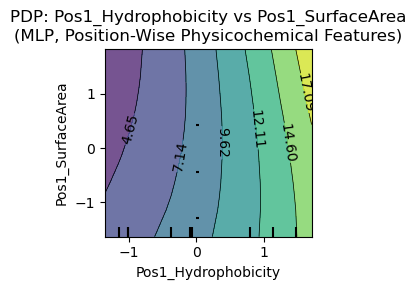

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos2_Hydrophobicity


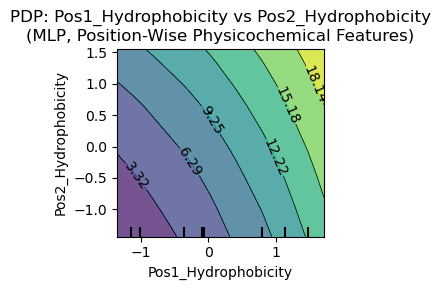

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos2_SurfaceArea


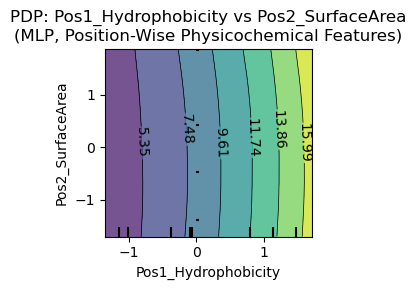

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos3_Hydrophobicity


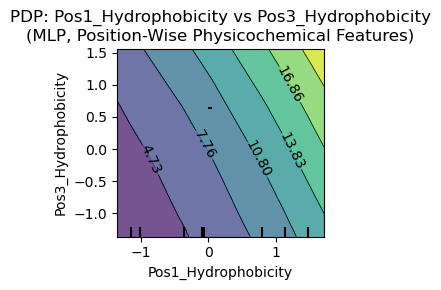

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos3_SurfaceArea


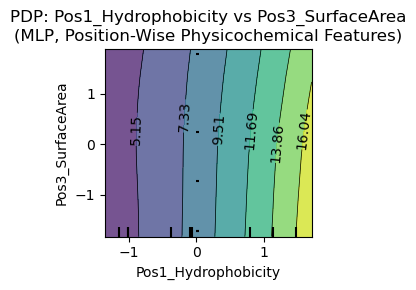

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos4_Hydrophobicity


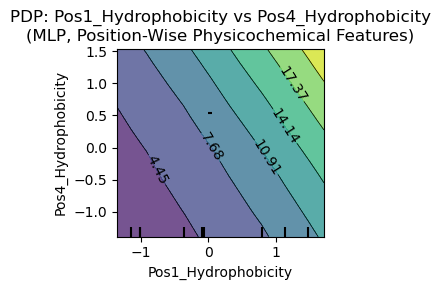

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos4_SurfaceArea


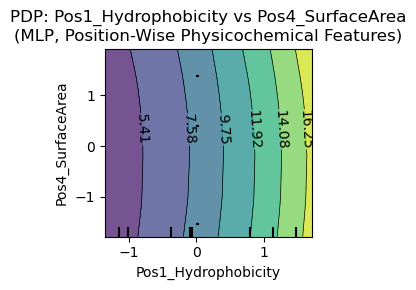

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos5_Hydrophobicity


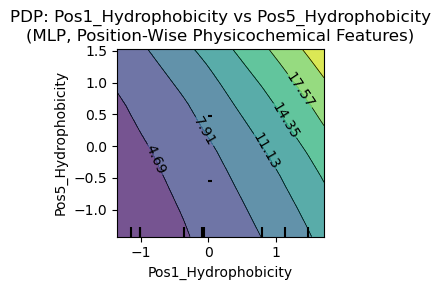

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos5_SurfaceArea


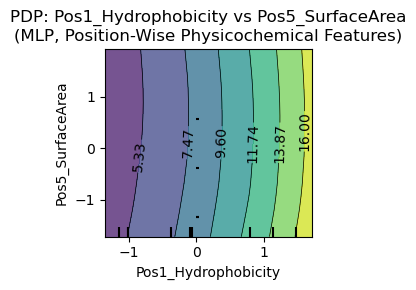

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos6_Hydrophobicity


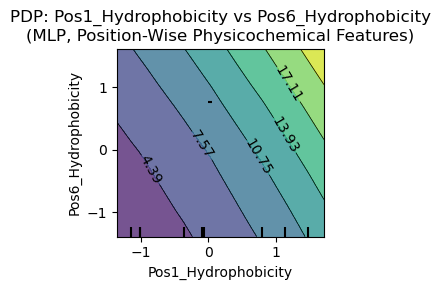

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos6_SurfaceArea


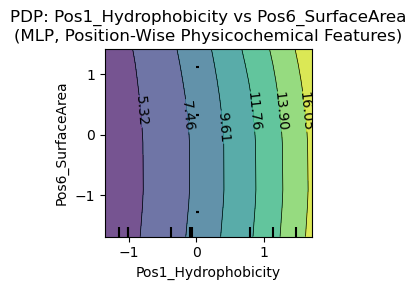

Plotting partial dependence for features: Pos1_Hydrophobicity & Pos7_Hydrophobicity


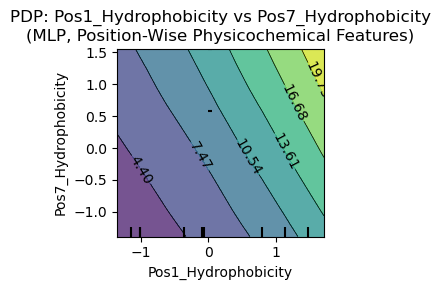

In [83]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

def plot_partial_dependence_pairs(model, X, feature_names, model_name, representation_name, pairs=None, max_pairs=5):
    """
    Plots partial dependence for pairs of features.
    Args:
        model: The trained model.
        X (np.ndarray): Feature data.
        feature_names (list): List of feature names.
        model_name (str): Name of the model for the plot title.
        representation_name (str): Name of the feature representation for the plot title.
        pairs (list of tuple): List of feature index pairs to plot. If None, will auto-generate.
        max_pairs (int): Maximum number of pairs to plot (for convenience).
    """
    from itertools import combinations
    import matplotlib.pyplot as plt
    from sklearn.inspection import PartialDependenceDisplay

    if pairs is None:
        # Generate all possible pairs, but limit to max_pairs for speed
        all_pairs = list(combinations(range(X.shape[1]), 2))
        pairs = all_pairs[:max_pairs]

    for idx, pair in enumerate(pairs):
        print(f"Plotting partial dependence for features: {feature_names[pair[0]]} & {feature_names[pair[1]]}")
        fig, ax = plt.subplots(figsize=(3,3))
        PartialDependenceDisplay.from_estimator(
            model, X, features=[pair], feature_names=feature_names,
            ax=ax, grid_resolution=30
        )
        ax.set_title(f"PDP: {feature_names[pair[0]]} vs {feature_names[pair[1]]}\n({model_name}, {representation_name})")
        plt.tight_layout()
        plt.show()

# Plot partial dependence for MLP model with position-wise physicochemical features
plot_partial_dependence_pairs(
    mlp_positionwise_model, X_test_pwp_scaled, 
    get_feature_names('position_wise', sequence_length=10), 
    "MLP", "Position-Wise Physicochemical Features", max_pairs=12
)

#plot_partial_dependence_pairs(
#    mlp_onehot_model, X_test_oh_scaled,
#    get_feature_names('one_hot', sequence_length=10),
#    "MLP", "One-Hot Encoded", max_pairs=100
#)